# Ray tracing: Cython with tuples

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
%load_ext Cython

In [4]:
%%cython
import numpy as np
cimport numpy as np
DBL = np.double
ctypedef np.double_t DBL_C
from libc.math cimport sqrt

cdef int w, h
w, h = 400, 400

cdef dot(tuple x, tuple y):
    return x[0] * y[0] + x[1] * y[1] + x[2] * y[2]

cdef normalize(tuple x):
    cdef double n
    n = sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2])
    return (x[0] / n, x[1] / n, x[2] / n)

cdef max(double x, double y):
    return x if x > y else y

cdef min(double x, double y):
    return x if x < y else y

cdef clip_(double x, double m, double M):
    return min(max(x, m), M)

cdef clip(tuple x, double m, double M):
    return (clip_(x[0], m, M), clip_(x[1], m, M), clip_(x[2], m, M),)

cdef add(tuple x, tuple y):
    return (x[0] + y[0], x[1] + y[1], x[2] + y[2])

cdef subtract(tuple x, tuple y):
    return (x[0] - y[0], x[1] - y[1], x[2] - y[2])

cdef minus(tuple x):
    return (-x[0], -x[1], -x[2])

cdef multiply(tuple x, tuple y):
    return (x[0] * y[0], x[1] * y[1], x[2] * y[2])

cdef multiply_s(tuple x, double c):
    return (x[0] * c, x[1] * c, x[2] * c)

cdef intersect_sphere(tuple O,
                      tuple D,
                      tuple S,
                      double R):
    # Return the distance from O to the intersection of the ray (O, D) with the
    # sphere (S, R), or +inf if there is no intersection.
    # O and S are 3D points, D (direction) is a normalized vector, R is a scalar.
    cdef double a, b, c, disc, distSqrt, q, t0, t1
    cdef tuple OS

    a = dot(D, D)
    OS = subtract(O, S)
    b = 2 * dot(D, OS)
    c = dot(OS, OS) - R * R
    disc = b * b - 4 * a * c
    if disc > 0:
        distSqrt = sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return float('inf')

cdef trace_ray(tuple O, tuple D,):

    cdef double t, radius, diffuse, specular_k, specular_c, DF, SP
    cdef tuple M, N, L, toL, toO, col_ray, \
        position, color, color_light, ambient

    # Sphere properties.
    position = (0., 0., 1.)
    radius = 1.
    color = (0., 0., 1.)
    diffuse = 1.
    specular_c = 1.
    specular_k = 50.

    # Light position and color.
    L = (5., 5., -10.)
    color_light = (1., 1., 1.)
    ambient = (.05, .05, .05)

    # Find first point of intersection with the scene.
    t = intersect_sphere(O, D, position, radius)
    # Return None if the ray does not intersect any object.
    if t == float('inf'):
        return
    # Find the point of intersection on the object.
    M = (O[0] + D[0] * t, O[1] + D[1] * t, O[2] + D[2] * t)
    N = normalize(subtract(M, position))
    toL = normalize(subtract(L, M))
    toO = normalize(subtract(O, M))
    DF = diffuse * max(dot(N, toL), 0)
    SP = specular_c * max(dot(N, normalize(add(toL, toO))), 0) ** specular_k

    return add(ambient, add(multiply_s(color, DF), multiply_s(color_light, SP)))

def run():
    cdef DBL_C[:,:,:] img = np.zeros((h, w, 3))
    cdef tuple img_
    cdef int i, j
    cdef double x, y
    cdef tuple O, Q, D, col_ray

    # Camera.
    O = (0., 0., -1.)  # Position.

    # Loop through all pixels.
    for i in range(w):
        for j in range(h):
            x = -1. + 2*float(i)/w
            y = -1. + 2*float(j)/h
            Q = (x, y, 0.)
            D = normalize(subtract(Q, O))
            col_ray = trace_ray(O, D)
            if col_ray is None:
                continue
            img_ = clip(col_ray, 0., 1.)
            img[h - j - 1, i, 0] = img_[0]
            img[h - j - 1, i, 1] = img_[1]
            img[h - j - 1, i, 2] = img_[2]
    return img

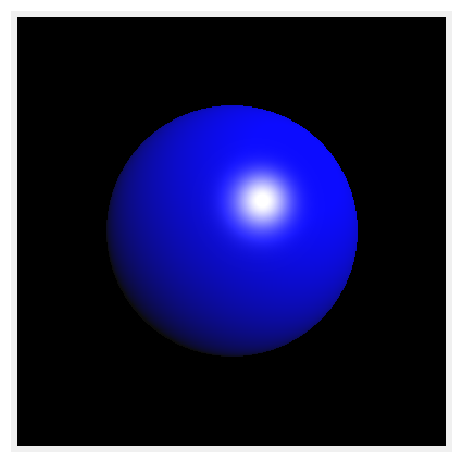

In [5]:
img = run()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img)
ax.set_axis_off()

In [6]:
%timeit run()

153 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs,
    10 loops each)
